<a href="https://colab.research.google.com/github/dwm-multimidia/dwm-multimidia.github.io/blob/master/lab7/jupyter/Lab7_CodificacaoVoz_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESTI019 - Codificação de Sinais Multimídia
# Lab7 - Codificação de Voz e Áudio
## Profs. Celso S. Kurashima e Mário Minami

# OBJETIVOS

1.   Determinação dos parâmetros LPC
2.   Separação Sonora/Surda
3.   Espectro e Envoltória LP
4.   Estimação da $f_0$ e do Pitch

In [32]:
!pip install audiolazy

from scipy import signal
from pathlib import Path
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display
import math
import audiolazy as lz
import shutil
import numpy as np

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
dirDrive = Path('/content/drive/MyDrive/lab7multimidia/')
if dirGit.exists():
  shutil.rmtree(dirGit)
dirDrive.mkdir(parents=True, exist_ok=True)
dirDrive.is_dir()

True

In [35]:
dirGit = Path('/content/dwm-multimidia.github.io/')
if dirGit.exists():
  shutil.rmtree(dirGit)

!git clone https://github.com/dwm-multimidia/dwm-multimidia.github.io.git

dirLab7 = dirGit.joinpath('lab7/audio/')
print('\nAgora temos acesso aos arquivos:\n\t', '\n\t '.join([str(arquivo) for arquivo in dirLab7.iterdir()]))

Cloning into 'dwm-multimidia.github.io'...
remote: Enumerating objects: 607, done.
remote: Counting objects: 100% (607/607), done.
remote: Compressing objects: 100% (467/467), done.
remote: Total 607 (delta 244), reused 414 (delta 112), pack-reused 0
Receiving objects: 100% (607/607), 209.58 MiB | 17.13 MiB/s, done.
Resolving deltas: 100% (244/244), done.
Checking out files: 100% (171/171), done.

Agora temos acesso aos arquivos:
	 /content/dwm-multimidia.github.io/lab7/audio/william4.wav
	 /content/dwm-multimidia.github.io/lab7/audio/audiodescricao_lab7.mp3
	 /content/dwm-multimidia.github.io/lab7/audio/Entre_Leva_Catia_Falada.wav
	 /content/dwm-multimidia.github.io/lab7/audio/matheus4.wav
	 /content/dwm-multimidia.github.io/lab7/audio/dimitri4.wav


## 0. Definindo o arquivo de áudio que será utilizado

In [77]:
audio1 = dirLab7.joinpath('william4.wav')

## 1. Separação de uma Estrofe

In [78]:
print(audio1)
v1 , sr1 = librosa.load(audio1)
print(type(v1), type(sr1))
print(v1.shape, sr1)
# Player será aberto! AGUARDE até abrir!
IPython.display.Audio(data=v1, rate=sr1)

/content/dwm-multimidia.github.io/lab7/audio/william4.wav
<class 'numpy.ndarray'> <class 'int'>
(244814,) 22050


<Figure size 432x288 with 0 Axes>

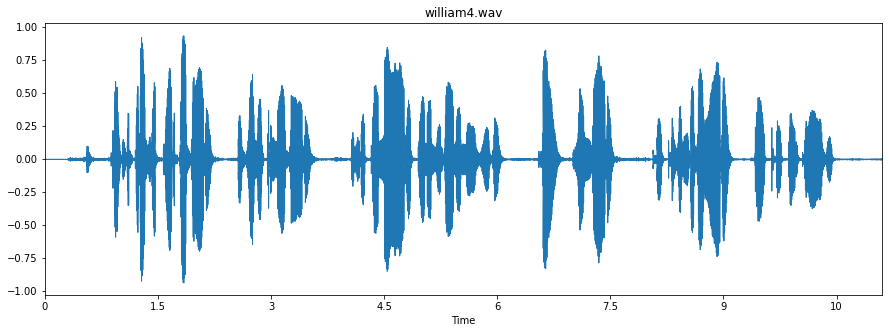

In [79]:
plt.figure()
fig, ax = plt.subplots(figsize=(15, 5))
librosa.display.waveplot(v1, sr=sr1)
plt.title(audio1.name)
plt.savefig(dirDrive.joinpath(audio1.name[:-4] + '_0.png'), bbox_inches='tight')
plt.show()

In [80]:
fa = sr1
Ts = 0.04
Nj = int(Ts*fa)
Nseg = int(len(v1)/Nj)
Nover = int(Nj*0.5)

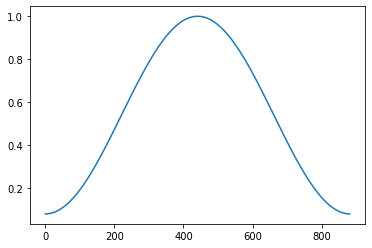

In [81]:
hm = signal.get_window('hamming', Nj)
plt.plot(hm)

<Figure size 432x288 with 0 Axes>

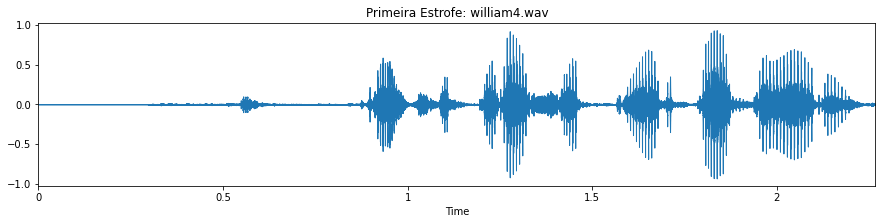

<class 'numpy.ndarray'> <class 'int'>
(49999,) 22050


In [82]:
# Só a primeira estrofe
v11 = v1[1:50000]
plt.figure()
fig11, ax11 = plt.subplots(figsize=(15, 3))
librosa.display.waveplot(v11, sr=sr1)
plt.title('Primeira Estrofe: ' + audio1.name)
plt.savefig(dirDrive.joinpath(audio1.name[:-4] + '_primeiraEstrofe.png'), bbox_inches='tight')
plt.show()
print(type(v11), type(sr1))
print(v11.shape, sr1)
# Player será aberto! AGUARDE até abrir!
IPython.display.Audio(data=v11, rate=sr1)

## 2. Cálculo dos Parâmetros LPC, separação U/UV e Espectro + Envoltória LPC

Limiar VAD 82.33950226470154
Limiar U/UV 85.03950226470154
Sonoros = 9 e Surdos = 3


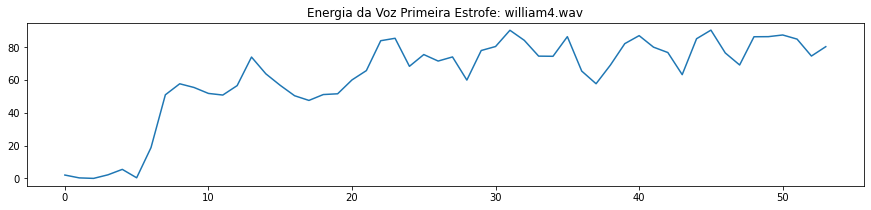

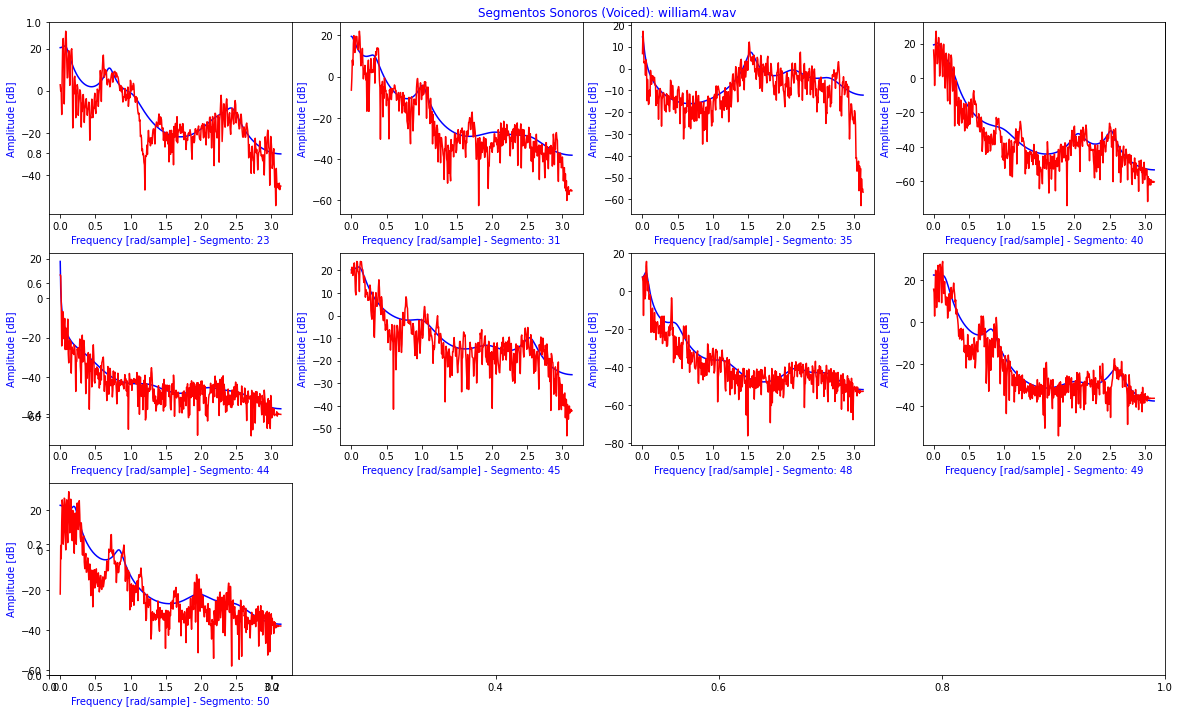

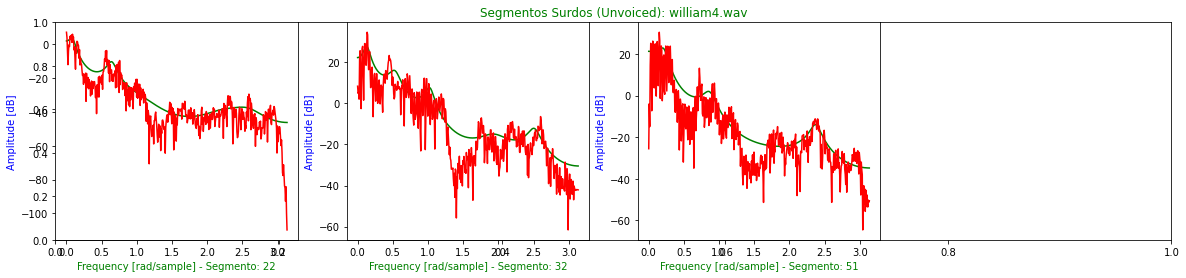

In [83]:
Nover = int(Nj*0.5)
Nseg1 = int(len(v11)/Nj)
p = 10
E = []
ind_voz = [0]*Nseg1
t = np.arange(Nj)
for l in range(1, Nseg1-1):
    xjan = v1[(l-1)*Nj+Nover:l*Nj+Nover]*hm
    x2 = list(np.array(xjan**2))
    aux = sum(x2)/Nj
    E.append(aux)
E1 = 10*np.log10(E)
E1min = np.min(E1)
E1 = E1 - E1min   # Coloca o ruído de fundo em 0 dB
E1max = np.max(E1)
# ****************************************************************
# OBSERVAÇÃO:
# ****************************************************************
# ATENÇÃO -> aqui nos arquivos que vocês gravam pode haver diferença
# nos limiares de VAD e U/UV
# É preciso ajustar ambos olhando para os níveis da 
# Energia de Tempo Curto E1
# ****************************************************************
# limiar de atividade VAD
E1VAD_lim = E1max - 8
print('Limiar VAD ' + str(E1VAD_lim))
# Limiar U/UV ajustado para 30% do máximo
E1voiced_lim = E1max - 5.3 
print('Limiar U/UV ' + str(E1voiced_lim))
# indicador de VAD
ind_voz = np.where(E1 > E1VAD_lim, 1, 0)
ind_voiced = np.where(E1 > E1voiced_lim, 1, 0)
tot_voz = np.sum(ind_voz)
num_voiced = np.sum(ind_voiced)
num_unvoiced = tot_voz - num_voiced
linhas_voiced = math.ceil(num_voiced/4)
linhas_unvoiced = math.ceil(num_unvoiced/4)

print('Sonoros = ' + str(num_voiced) + ' e Surdos = ' + str(num_unvoiced) )
fig1, ax1 = plt.subplots(figsize=(15, 3))
plt.figure(1)
plt.plot(E1)
plt.title('Energia da Voz Primeira Estrofe: ' + audio1.name)

# partição das figuras voiced
i = 0
fig2, ax2 = plt.subplots(figsize=(20, num_voiced + linhas_voiced))
plt.title('Segmentos Sonoros (Voiced): ' + audio1.name, color = 'b')

# partição das figuras unvoiced
j = 0
fig3, ax3 = plt.subplots(figsize=(20, num_unvoiced + linhas_unvoiced))
plt.title('Segmentos Surdos (Unvoiced): ' + audio1.name, color = 'g')

for l in range(1, Nseg1-2):
    # teste de VAD 
    if ind_voz[l] == 1:
        xjan = v1[(l-1)*Nj+Nover:l*Nj+Nover]*hm
        a_filter = lz.lpc.kautocor(xjan, p) 
        gain_lpc = np.log10(abs(a_filter.error))
        w, h = signal.freqz(1,a_filter.numerator,worN=int(Nj/2))
        LP = 20 * np.log10(abs(h)) + 10*gain_lpc
        # Teste U/UV
       
        if E1[l] > E1voiced_lim:
            i += 1
            ax2 = fig2.add_subplot(linhas_voiced,4,i)
            plt.figure(2)          
            plt.plot(w, LP, 'b')
            plt.ylabel('Amplitude [dB]', color='b')
            plt.xlabel('Frequency [rad/sample] - Segmento: ' + str(l), color='b')     
            sp = np.fft.fft(xjan)
            plt.plot(w, 20*np.log10(abs(sp[0:int(Nj/2)])), 'r')
        else:
            j += 1
            ax3 = fig3.add_subplot(linhas_unvoiced,4,j)           
            plt.figure(3)            
            plt.plot(w, LP, 'g')
            plt.ylabel('Amplitude [dB]', color='b')
            plt.xlabel('Frequency [rad/sample] - Segmento: ' + str(l), color='g')     
            sp = np.fft.fft(xjan)
            plt.plot(w, 20*np.log10(abs(sp[0:int(Nj/2)])), 'r')

fig1.savefig(dirDrive.joinpath(audio1.name[:-4] + '_energia.png'), bbox_inches='tight')
fig2.savefig(dirDrive.joinpath(audio1.name[:-4] + '_segmentosSonoros.png'), bbox_inches='tight')
fig3.savefig(dirDrive.joinpath(audio1.name[:-4] + '_segmentosSurdos.png'), bbox_inches='tight')

# 3. Estimação da $f_0$ e do Pitch

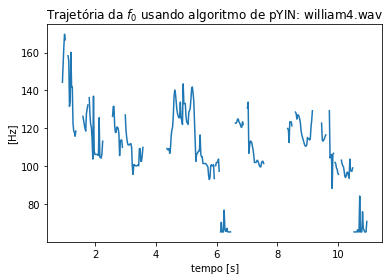

In [85]:
f0, voiced_flag, voiced_probs = librosa.pyin(v1, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C5'))
times = librosa.times_like(f0)
plt.plot(times,f0)
plt.ylabel('[Hz]')
plt.xlabel('tempo [s]')
plt.title('Trajetória da $f_0$ usando algoritmo de pYIN: ' + audio1.name)
plt.savefig(dirDrive.joinpath(audio1.name[:-4] + '_trajetoriaF0PYIN.png'), bbox_inches='tight')
plt.show()

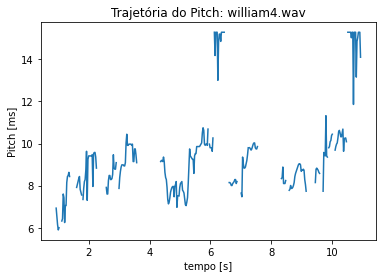

In [86]:
pitch = 1/f0
plt.plot(times,1000*pitch)
plt.ylabel('Pitch [ms]')
plt.xlabel('tempo [s]')
plt.title('Trajetória do Pitch: ' + audio1.name)
plt.savefig(dirDrive.joinpath(audio1.name[:-4] + '_trajetoriaPitch.png'), bbox_inches='tight')
plt.show()

Espectrograma enfatizando a $f_0$ 

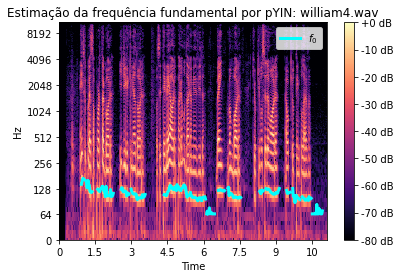

In [87]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(v1)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Estimação da frequência fundamental por pYIN: ' + audio1.name)
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='$f_0$', color='cyan', linewidth=3)
ax.legend(loc='upper right')
fig.savefig(dirDrive.joinpath(audio1.name[:-4] + '_estimacaoFundamental.png'), bbox_inches='tight')